In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

In [3]:
%cd /content/ImageBind

/content/ImageBind


In [4]:
import logging
import math

import torch
import torch.nn as nn
import torchaudio
from PIL import Image
from pytorchvideo import transforms as pv_transforms
from pytorchvideo.data.clip_sampling import ConstantClipsPerVideoSampler
from pytorchvideo.data.encoded_video import EncodedVideo
from torchvision import transforms
from torchvision.transforms._transforms_video import NormalizeVideo

from imagebind.models.multimodal_preprocessors import SimpleTokenizer

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [5]:
import torchaudio
import torch

DEFAULT_AUDIO_FRAME_SHIFT_MS = 10

def waveform2melspec(waveform, sample_rate, num_mel_bins, target_length):
    # Based on https://github.com/YuanGongND/ast/blob/d7d8b4b8e06cdaeb6c843cdb38794c1c7692234c/src/dataloader.py#L102
    waveform -= waveform.mean()
    fbank = torchaudio.compliance.kaldi.fbank(
        waveform,
        htk_compat=True,
        sample_frequency=sample_rate,
        use_energy=False,
        window_type="hanning",
        num_mel_bins=num_mel_bins,
        dither=0.0,
        frame_length=25,
        frame_shift=DEFAULT_AUDIO_FRAME_SHIFT_MS,
    )
    # Convert to [mel_bins, num_frames] shape
    fbank = fbank.transpose(0, 1)
    # Pad to target_length
    n_frames = fbank.size(1)
    p = target_length - n_frames
    # if p is too large (say >20%), flash a warning
    if abs(p) / n_frames > 0.2:
        logging.warning(
            "Large gap between audio n_frames(%d) and "
            "target_length (%d). Is the audio_target_length "
            "setting correct?",
            n_frames,
            target_length,
        )
    # cut and pad
    if p > 0:
        fbank = torch.nn.functional.pad(fbank, (0, p), mode="constant", value=0)
    elif p < 0:
        fbank = fbank[:, 0:target_length]
    # Convert to [1, mel_bins, num_frames] shape, essentially like a 1
    # channel image
    fbank = fbank.unsqueeze(0)
    return fbank

def get_clip_timepoints(clip_sampler, duration):
    # Read out all clips in this video
    all_clips_timepoints = []
    is_last_clip = False
    end = 0.0
    while not is_last_clip:
        start, end, _, _, is_last_clip = clip_sampler(end, duration, annotation=None)
        all_clips_timepoints.append((start, end))
    return all_clips_timepoints

def load_and_transform_audio_data(
    audio_paths,
    device,
    num_mel_bins=128,
    target_length=204,
    sample_rate=16000,
    clip_duration=2,
    clips_per_video=3,
    mean=-4.268,
    std=9.138,
):
    if audio_paths is None:
        return None

    audio_outputs = []
    clip_sampler = ConstantClipsPerVideoSampler(
        clip_duration=clip_duration, clips_per_video=clips_per_video
    )

    for audio_path in audio_paths:
        waveform, sr = torchaudio.load(audio_path)
        if sample_rate != sr:
            waveform = torchaudio.functional.resample(
                waveform, orig_freq=sr, new_freq=sample_rate
            )
        all_clips_timepoints = get_clip_timepoints(
            clip_sampler, waveform.size(1) / sample_rate
        )
        all_clips = []
        for clip_timepoints in all_clips_timepoints:
            waveform_clip = waveform[
                :,
                int(clip_timepoints[0] * sample_rate) : int(
                    clip_timepoints[1] * sample_rate
                ),
            ]
            waveform_melspec = waveform2melspec(
                waveform_clip, sample_rate, num_mel_bins, target_length
            )
            all_clips.append(waveform_melspec)

        normalize = transforms.Normalize(mean=mean, std=std)
        all_clips = [normalize(ac).to(device) for ac in all_clips]

        all_clips = torch.stack(all_clips, dim=0)
        audio_outputs.append(all_clips)

    return torch.stack(audio_outputs, dim=0)


# Example audio paths - replace these with your audio paths
audio_paths = ["/content/drive/MyDrive/Data_Mining_CMPE_255/AudioBind/03-01-01-01-01-02-01.wav", "/content/drive/MyDrive/Data_Mining_CMPE_255/AudioBind/03-01-01-01-01-02-02.wav",
               "/content/drive/MyDrive/Data_Mining_CMPE_255/AudioBind/03-01-01-01-01-02-03.wav", "/content/drive/MyDrive/Data_Mining_CMPE_255/AudioBind/03-01-02-02-01-02-03.wav",
               "/content/drive/MyDrive/Data_Mining_CMPE_255/AudioBind/03-01-02-02-02-01-01.wav", "/content/drive/MyDrive/Data_Mining_CMPE_255/AudioBind/03-01-05-02-02-01-02.wav"]

device = "cuda:0" if torch.cuda.is_available() else "cpu"
audio_data = load_and_transform_audio_data(audio_paths, device)

In [6]:
%cd /content/ImageBind

/content/ImageBind


In [7]:
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Instantiate the model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Process the audio data
inputs = {
    ModalityType.AUDIO: audio_data
}

with torch.no_grad():
    embeddings = model(inputs)

# 'embeddings' will contain the audio embeddings

In [8]:
print(embeddings)

{'audio': tensor([[ 0.0294,  0.0157, -0.2768,  ...,  0.3413, -0.0751, -0.3296],
        [ 0.2094, -0.2347,  0.1237,  ...,  0.2035,  0.1696, -0.0522],
        [-0.2076, -0.0153,  0.3324,  ...,  0.3169,  0.1558, -0.5687],
        [-0.1162,  0.0930, -0.0915,  ..., -0.0051,  0.1350, -0.3716],
        [-0.0079, -0.5312, -0.1012,  ..., -0.4574, -0.1859,  0.2529],
        [-0.1030,  0.0220, -0.0521,  ...,  0.4341,  0.0295, -0.0183]],
       device='cuda:0')}


In [9]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming `embeddings` is your dictionary containing the audio embeddings
embeddings_tensor = embeddings['audio']

# Move the tensor to CPU and convert to NumPy array
embeddings_2d = embeddings_tensor.cpu().numpy()

# Define the number of clusters
num_clusters = 2  # Adjust based on your needs

# Initialize and fit the k-means model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings_2d)

# 'clusters' now contains the cluster assignment for each audio segment

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


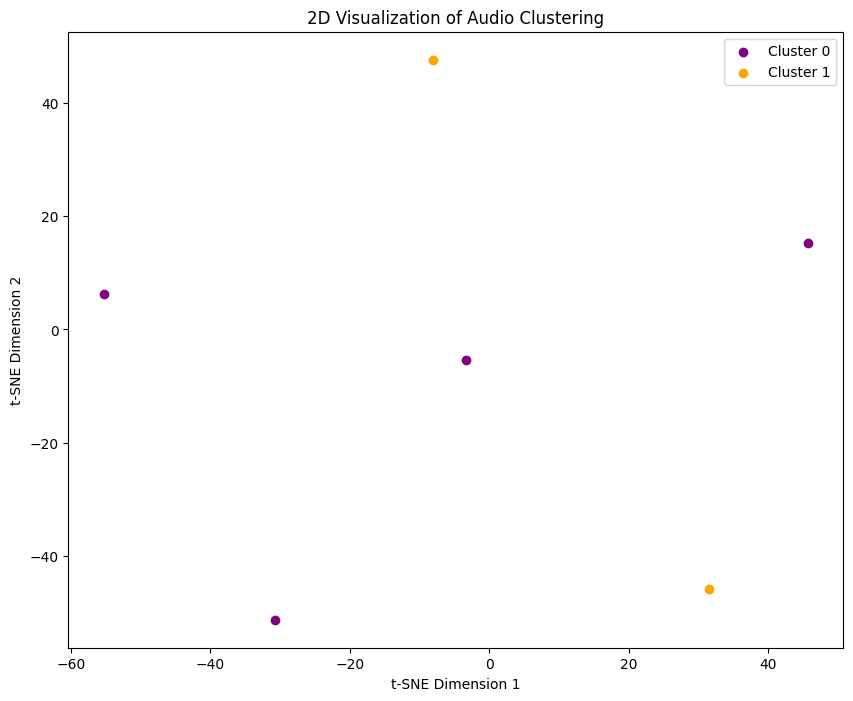

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Number of data points
n_samples = len(embeddings_2d)

# Adjusting perplexity to be less than the number of samples
perplexity_value = min(30, n_samples - 1)

# Applying t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_2d)

# Plotting
plt.figure(figsize=(10, 8))
colors = ['purple', 'orange']  # Adjust based on num_clusters
for i in range(num_clusters):
    cluster_indices = np.where(clusters == i)[0]
    plt.scatter(reduced_embeddings[cluster_indices, 0], reduced_embeddings[cluster_indices, 1],
                c=colors[i], label=f'Cluster {i}')

plt.title('2D Visualization of Audio Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


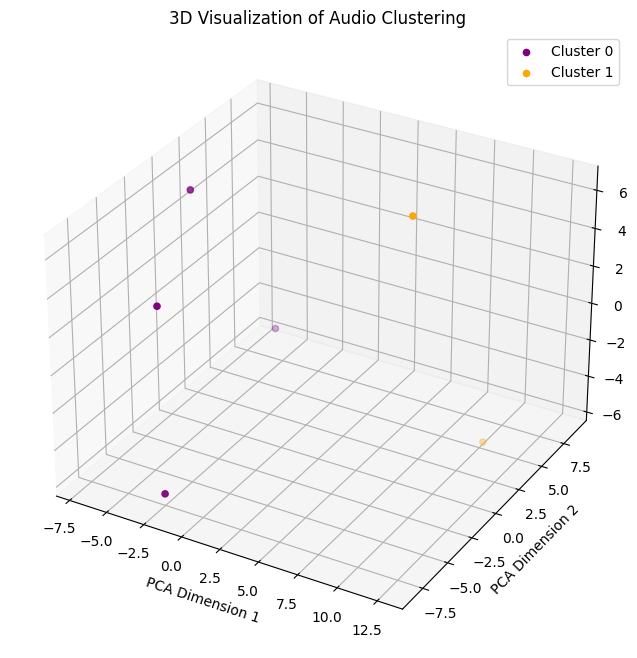

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reducing the embeddings to 3 dimensions using PCA
pca = PCA(n_components=3)
reduced_embeddings_3d = pca.fit_transform(embeddings_2d)

# 3D Scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['purple', 'orange']
for i in range(num_clusters):
    cluster_indices = np.where(clusters == i)[0]
    ax.scatter(reduced_embeddings_3d[cluster_indices, 0], reduced_embeddings_3d[cluster_indices, 1], reduced_embeddings_3d[cluster_indices, 2], c=colors[i], label=f'Cluster {i}')

ax.set_title('3D Visualization of Audio Clustering')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.legend()

plt.show()